In [1]:
import numpy as np 
from qiskit import QuantumRegister, ClassicalRegister,QuantumCircuit, transpile, Aer
from qiskit import IBMQ, Aer
from qiskit.providers.aer import QasmSimulator
from qiskit.providers.aer.noise import NoiseModel
from Hamming import *
import qiskit
%matplotlib inline
from random import randint

In [2]:
# Create a hamming circuit
N = 3
sizeDec=HammingSize(N,'decoder')
sizeEnc=HammingSize(N,'encoder')
circuit = QuantumCircuit(sizeDec,sizeDec)

# Create a input
circuit.h(0)
circuit.cx(0,1)
circuit.x(1)
circuit.cx(0,2)

# Add the encoder to the circuit
circuit.append(HammingEncode(N), range(sizeEnc))

# Add errors
circuit.y(4)

# Add the decoder to the circuit
circuit.append(HammingDecode(N,read=True),range(sizeDec))

# Measure the qubits
circuit.measure(list(range(N)),list(range(N)))

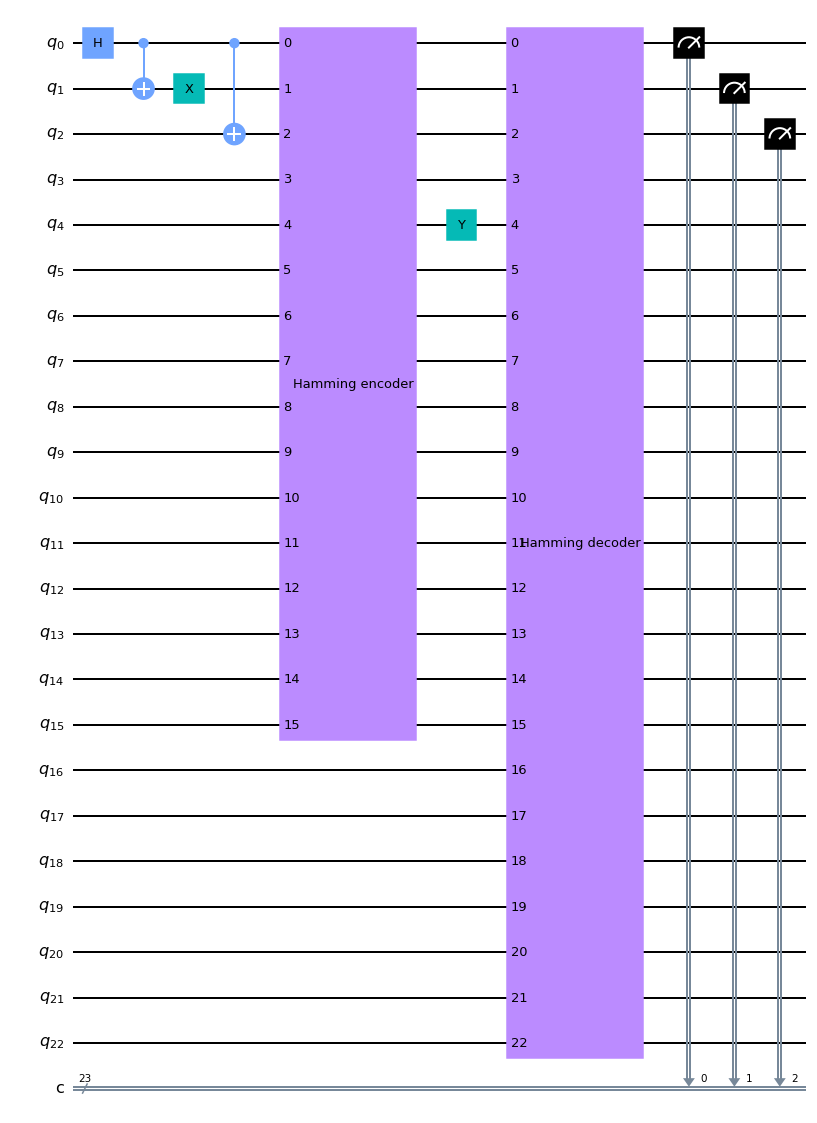

In [3]:
circuit.draw(output='mpl')

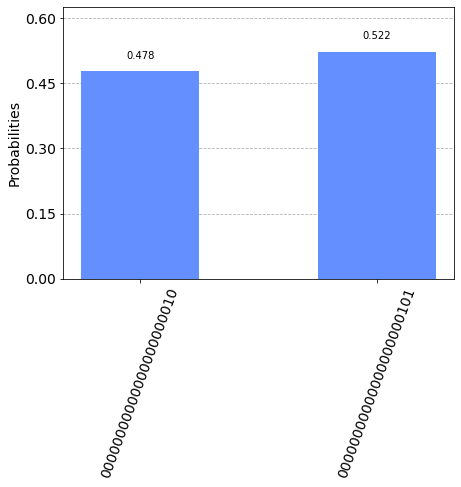

In [4]:
# Simulate the circuit
simulator = Aer.get_backend("qasm_simulator")
result = qiskit.execute(circuit, backend = simulator, shots=1000).result()

from qiskit.tools.visualization import plot_histogram
plot_histogram(result.get_counts(circuit))

In [5]:
from qiskit.providers.aer.noise import NoiseModel #zz noise model

In [6]:
#Needed in order to load the ibm-mps simulator for an optimal simulation
provider = IBMQ.load_account()
##zz the following adds the noise model that is based on ibmq_vigo
##zz backend = provider.get_backend('ibmq_vigo') #zz noise model from real machines
backend = provider.get_backend('ibmq_16_melbourne')
noise_model = NoiseModel.from_backend(backend) #zz noise model from real machines

# Get coupling map from backend
##zz coupling_map = backend.configuration().coupling_map #zz noise model from real machines

##zz The following adds custom noise model to the circuit
# Error probabilities
##zz prob_1 = 0.001  # 1-qubit gate
##zz prob_2 = 0.01   # 2-qubit gate

# Depolarizing quantum errors
##zz error_1 = noise.depolarizing_error(prob_1, 1)
##zz error_2 = noise.depolarizing_error(prob_2, 2)
##zz error_1 = NoiseModel.depolarizing_error(prob_1, 1)
##zz error_2 = NoiseModel.depolarizing_error(prob_2, 2)

# Add errors to noise model
##zz noise_model = noise.NoiseModel()
##zz noise_model = NoiseModel.NoiseModel()
##zz noise_model.add_all_qubit_quantum_error(error_1, ['u1', 'u2', 'u3'])
##zz noise_model.add_all_qubit_quantum_error(error_2, ['cx'])

# Get basis gates from noise model
basis_gates = noise_model.basis_gates
print("\n", basis_gates)
##zz basis_gates = ['cx', 'id', 'rz', 'sx', 'x']
basis_gates = ['cx', 'id', 'u1', 'sx', 'x']
##zz end of initialization of noise
print(basis_gates)


 ['cx', 'id', 'rz', 'sx', 'x']
['cx', 'id', 'u1', 'sx', 'x']


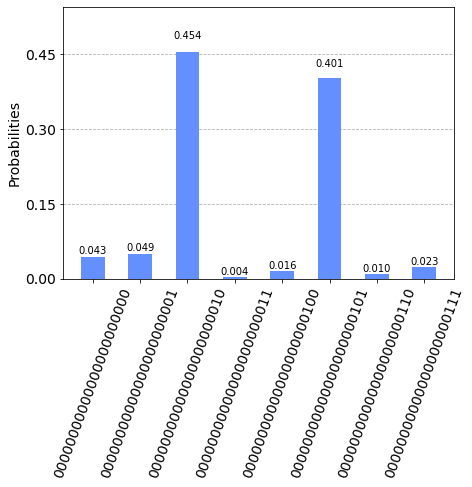

In [7]:
result_noise = qiskit.execute(circuit, backend = simulator, shots=1000, 
                              #zz coupling_map=coupling_map,
                              # basis_gates=basis_gates,
                              noise_model=noise_model).result()

from qiskit.tools.visualization import plot_histogram
plot_histogram(result_noise.get_counts(circuit))